# Second attempt at building a RISE explainer for embedded spaces

In the previous notebook we built a first attempt using two labra doodles. We had some success, but still need:
1. more understanding of the output and
2. need to run on several examples to get a feeling of the robustness of the method and
3. also to assess its performance on very different images (since we focused on very similar images before).

We also at some point will look into multimodal models, but this will require changing the API to input two models. This we will do in a next step, after we understand the basics better.

Image combinations to try out here:
- Bee vs fly (similar in insectiness but also differences)
- Flower vs car
- Car vs bike
- Image with both "cat and labradoodle" vs cat and vs labradoodle.

We need to take care with backgrounds that could be distinguishing, probably keep them similar when trying to focus on the actual objects? Or not, but in any case, let's be aware.

In [11]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import pairwise_distances

In [8]:
import embeddings

In [49]:
import importlib
importlib.reload(embeddings)

<module 'embeddings' from '/Users/pbos/projects/dianna/dianna/embedding_WIP/embeddings.py'>

In [14]:
model = embeddings.Model()

In [21]:
urls = ['https://www.keystonepuppies.com/wp-content/uploads/2019/05/Tike-Mini-Labradoodle.jpg',
        'https://www.lomondhillslabradoodles.co.uk/wp-content/uploads/2018/12/IMG_4531-e1549365547619.jpg']
filenames = [embeddings.download(url) for url in urls]

img_dog1, x_dog1 = embeddings.load_img(filenames[0], model.input_size)
img_dog2, x_dog2 = embeddings.load_img(filenames[1], model.input_size)

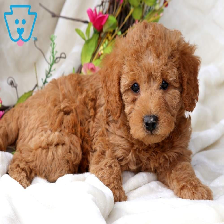

In [27]:
img_dog1

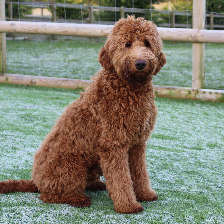

In [24]:
img_dog2

In [67]:
def get_masked_predictions(model, inp, masks, batch_size=10):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    N = len(masks)
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    return preds

def explain(model, inp, reference_inp, masks, batch_size=10, preds=None):
    if preds is None:
        preds = get_masked_predictions(model, inp, masks, batch_size=batch_size)

    reference_pred = model.run_on_batch(reference_inp)
    distances = pairwise_distances(preds, reference_pred, metric='cosine') / 2
    mask_weights = np.exp(-distances)
    print('weights.shape', mask_weights.shape)

    sal = mask_weights.T.dot(masks.reshape(len(masks), -1)).reshape(-1, *model.input_size)

    normalization = mask_weights.sum()

    sal = sal / normalization
    return sal

In [71]:
masks = embeddings.generate_masks(3000, 8, 0.5, model.input_size)

Generating masks: 100%|██████████| 3000/3000 [00:10<00:00, 275.80it/s]


In [72]:
masked_predictions = get_masked_predictions(model, x_dog1, masks)

Explaining: 100%|██████████| 300/300 [04:15<00:00,  1.18it/s]


In [73]:
sal = explain(model, x_dog1, x_dog2, masks, preds=masked_predictions)

weights.shape (3000, 1)


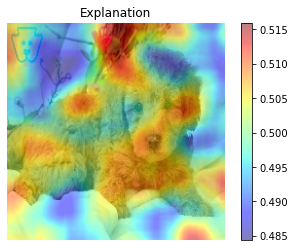

In [74]:
fig = embeddings.plot_explainer(img_dog1, sal[0])